# Utilizando un modelo pre-entrenado

[`torchvision.models`](https://pytorch.org/vision/stable/models.html) ofrece una gran cantidad de modelos de la literatura de *deep learning* que pueden utilizarse de forma directa. 

Por defecto, cuando se carga un modelo de `models`,  los pesos son aleatorios. Es decir que cargamos una arquitectura que no está entrenada. En cambio si indicamos una de las opciones posibles para el argumento `weights` en el constructor del modelo, se descargará un modelo entrenado. 

A continuación veremos algunos ejemplos de modelos para clasificar, localizar y segmentar.

## Modelo para clasificar imágenes

`torchvision` tiene una basta cantidad de modelos para clasificar incluyendo distintas versiones de VGG, ResNet, AlexNet, GoogLeNet, DenseNet, entre otros.

A continuación se carga un modelo [resnet18](https://arxiv.org/pdf/1512.03385.pdf) [pre-entrenado](https://pytorch.org/vision/stable/models/generated/torchvision.models.resnet18.html#torchvision.models.resnet18) con el famoso dataset [ImageNet](http://image-net.org/).

In [1]:
%matplotlib inline
import numpy as np
from matplotlib import pyplot as plt

from torchvision import models

model = models.resnet18(weights=models.resnet.ResNet18_Weights.IMAGENET1K_V1)
model.eval();

Los modelos pre-entrenados esperan imágenes con

- tres canales (RGB)
- al menos 224x224 píxeles
- píxeles entre 0 y 1 (float)

Además los canales deben estar normalizados según: 

```python
normalize = torchvision.transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                             std=[0.229, 0.224, 0.225])
```


Preparamos una imagen para inferir su clase con Resnet18.

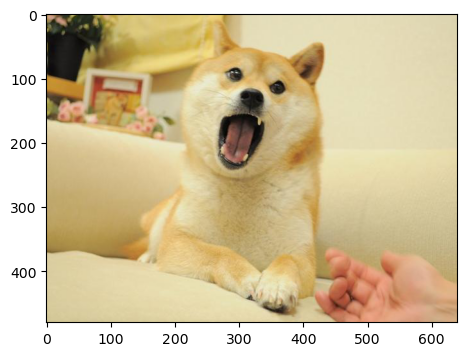

In [2]:
from PIL import Image

img = Image.open("img/dog.jpg")

fig, ax = plt.subplots(figsize=(6, 4))
ax.imshow(img);

Si la normalizamos según la transformación anterior se obtiene:

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


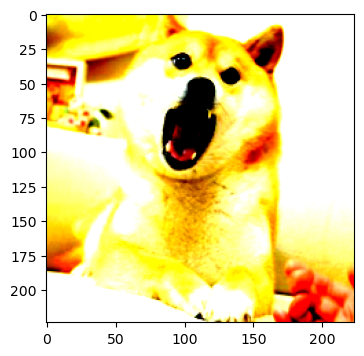

In [3]:
import torch
from torchvision import transforms

TL_transform = transforms.Compose([transforms.Resize(256),
                                   transforms.CenterCrop(224),
                                   transforms.ToTensor(),
                                   transforms.Normalize(mean=(0.485, 0.456, 0.406), 
                                                        std=(0.229, 0.224, 0.225))])
normalized_img = TL_transform(img)

fig, ax = plt.subplots(figsize=(6, 4))

ax.imshow(normalized_img.permute(dims=[1, 2, 0]).detach().numpy());

Luego podemos evaluar el modelo con la nueva imagen:

In [4]:
import torch.nn as nn

probs = nn.Softmax(dim=1)(model.forward(normalized_img.unsqueeze(0)))

Este modelo tiene  

In [5]:
len(probs[0, :])

1000

neuronas de salida (clases). Estudiemos las cinco clases más probables según el modelo:

In [6]:
import urllib.request, json 
with urllib.request.urlopen("https://s3.amazonaws.com/deep-learning-models/image-models/imagenet_class_index.json") as url:
    labels = json.load(url)
    
best = probs.argsort(descending=True)

print("idx prob name")
for entity in best[0, :5].numpy():
    print(entity, probs[0, entity].detach(), labels[str(entity)][1])

idx prob name
263 tensor(0.2759) Pembroke
151 tensor(0.1574) Chihuahua
259 tensor(0.1539) Pomeranian
273 tensor(0.1503) dingo
260 tensor(0.1461) chow


## Modelo para detectar entidades en imágenes

Adicional a los modelos de clasificación `torchvision` también tiene modelos de:

- Detección de objetos/entidades: Faster RCNN, SSD, RetinaNet
- Segmentación por instancia: Mask RCNN
- Segmentación semántica: FCC, DeepLab
- Clasificación de video

A continuación probaremos la [Faster RCNN](https://arxiv.org/abs/1506.01497) para hace detección. Este modelo fue pre-entrenado en la base de datos [COCO](https://cocodataset.org/).

El modelo retorna un diccionario con:

- 'boxes': Los bounding box de las entidades
- 'labels': La etiqueta de la clase más probable de la entidad
- 'score': La probabilidad de la etiqueta


In [7]:
model = models.detection.fasterrcnn_resnet50_fpn(weights=models.detection.FasterRCNN_ResNet50_FPN_Weights.COCO_V1)
model.eval()

transform = transforms.ToTensor()
img = Image.open("img/pelea.jpg") # No require normalización de color
img_tensor = transform(img)

result = model(img_tensor.unsqueeze(0))[0]

def filter_results(result, threshold=0.9):
    mask = result['scores'] > threshold
    bbox = result['boxes'][mask].detach().cpu().numpy()
    lbls = result['labels'][mask].detach().cpu().numpy()
    return bbox, lbls

A continuación se muestran algunas de las clases con sus bounding boxes dibujados sobre la imagen original:

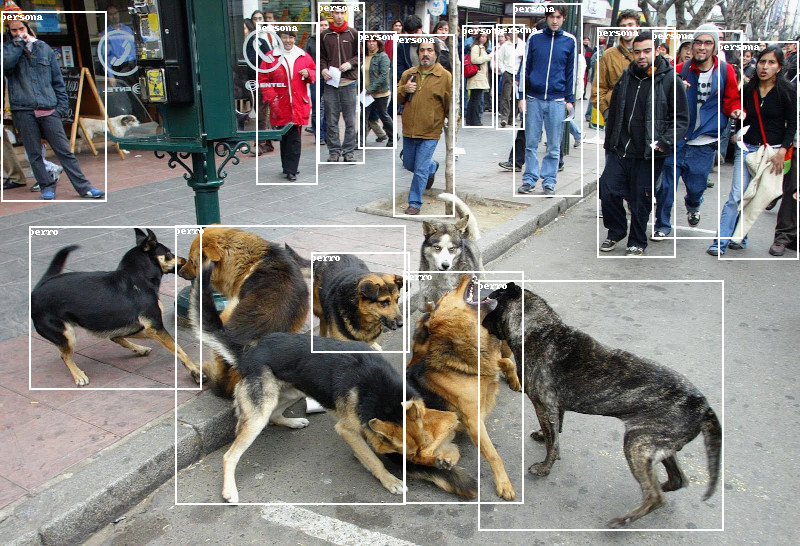

In [8]:
from PIL import ImageFont, ImageDraw
#fnt = ImageFont.truetype("arial.ttf", 20) 

label2name = {1: 'persona', 2: 'bicicleta', 3: 'auto', 4: 'moto', 
              8: 'camioneta', 18: 'perro'}

def draw_rectangles(img, bbox, lbls):
    draw = ImageDraw.Draw(img)
    for k in range(len(bbox)):
        if lbls[k] in label2name.keys():
            draw.rectangle(bbox[k], fill=None, outline='white', width=2)
            draw.text([int(d) for d in bbox[k][:2]], label2name[lbls[k]], fill='white')

bbox, lbls = filter_results(result)
img = Image.open("img/pelea.jpg")
draw_rectangles(img, bbox, lbls)
display(img)

## Transferencia de Aprendizaje


A continuación usaremos la técnica de transferencia de aprendizaje para entrenar un clasificador de imágenes utilizando un fragmento de la base de datos [*Food-5K*](https://www.kaggle.com/datasets/trolukovich/food5k-image-dataset). El objetivo es clasificar si la imagen corresponde a comida o no.

Guardamos las imagenes con la siguiente estructura de carpetas:

In [9]:
!ls data/food5k/
!ls data/food5k/train
!ls data/food5k/valid

 train   valid
 food   non_food
 food   non_food


Dada esta estructura podemos utilizar `torchvision.datasets.ImageFolder` para crear los dataset de forma directa. 

Como utilizaremos un modelo de clasificación preentrenado debemos transformar las imágenes según lo explicado anteriormente.

Adicionalmente se hará aumentación de datos en el conjunto de entrenamiento.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


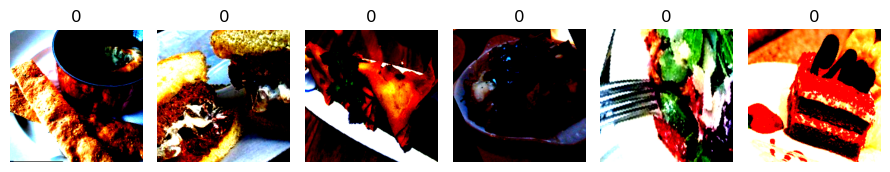

In [10]:
from torchvision import datasets

train_transforms = transforms.Compose([transforms.RandomRotation(30),
                                       transforms.RandomResizedCrop(224),
                                       transforms.RandomHorizontalFlip(),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])])

valid_transforms = transforms.Compose([transforms.Resize(255),
                                       transforms.CenterCrop(224),
                                       transforms.ToTensor(),
                                       transforms.Normalize([0.485, 0.456, 0.406],
                                                            [0.229, 0.224, 0.225])])

train_dataset = datasets.ImageFolder('data/food5k/train', transform=train_transforms)
valid_dataset = datasets.ImageFolder('data/food5k/valid', transform=valid_transforms)
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_loader = torch.utils.data.DataLoader(valid_dataset, batch_size=256, shuffle=False)

# 6 imágenes de ejemplo:
fig, ax = plt.subplots(1, 6, figsize=(9, 2), tight_layout=True)
for i in range(6):
    image, label = train_dataset[i]
    ax[i].imshow(image.permute(1,2,0).numpy())
    ax[i].axis('off')
    ax[i].set_title(label)

Usaremos el modelo ResNet18:

In [11]:
model = models.resnet18(weights=models.resnet.ResNet18_Weights.IMAGENET1K_V1)

Estudiemos la estructura de este modelo:

In [12]:
model

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

En este caso re-entrenaremos sólo la última capa, llamada `fc`. Esta es la capa que se encarga de clasificar.

Las demás capas serán congeladas, es decir, no propagaremos gradiente. De esta forma evitamos sobreajustar el modelo con este conjunto de datos pequeño.

Para congelar una capa simplemente usamos `requires_grad=False` en sus parámetros. Cuando llamemos `backward` no se calculará gradiente para estas capas.

In [13]:
for param in model.parameters(): 
    param.requires_grad = False

Ahora podemos crear una nueva capa de salida que reemplaza a `fc`.

:::{note}

El problema tiene dos clases, por lo tanto configuramos la capa `fc` con dos neuronas de salida.

:::

In [14]:
model.fc = torch.nn.Linear(model.fc.in_features , 2)  # Para resnet

Luego entrenamos de forma usual:

In [15]:
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

for epoch in range(10):
    epoch_loss, acc = 0.0, 0.0
    for x, y in train_loader:
        optimizer.zero_grad()
        yhat = model(x)
        loss = criterion(yhat, y)
        loss.backward()
        optimizer.step()
        epoch_loss += loss.item()
        acc += torch.sum(yhat.argmax(dim=1) == y).item()
    epoch_loss /= len(train_loader.dataset)
    acc /= len(train_loader.dataset)
    print(f"Train {epoch}, Loss: {epoch_loss:0.4f}, Acc: {acc:0.3f}")
    
    epoch_loss, acc = 0.0, 0.0
    for x, y in valid_loader:
        yhat = model(x)
        loss = criterion(yhat, y)
        epoch_loss += loss.item()
        acc += torch.sum(yhat.argmax(dim=1) == y).item()
    epoch_loss /= len(valid_loader.dataset)
    acc /= len(valid_loader.dataset)
    print(f"Valid {epoch}, Loss: {epoch_loss:0.4f}, Acc: {acc:0.3f}")
    

Train 0, Loss: 0.0349, Acc: 0.404
Valid 0, Loss: 0.0079, Acc: 0.530
Train 1, Loss: 0.0221, Acc: 0.577
Valid 1, Loss: 0.0059, Acc: 0.670
Train 2, Loss: 0.0161, Acc: 0.788
Valid 2, Loss: 0.0040, Acc: 0.860
Train 3, Loss: 0.0121, Acc: 0.909
Valid 3, Loss: 0.0032, Acc: 0.910
Train 4, Loss: 0.0103, Acc: 0.933
Valid 4, Loss: 0.0026, Acc: 0.930
Train 5, Loss: 0.0084, Acc: 0.909
Valid 5, Loss: 0.0023, Acc: 0.950
Train 6, Loss: 0.0084, Acc: 0.933
Valid 6, Loss: 0.0021, Acc: 0.940
Train 7, Loss: 0.0079, Acc: 0.938
Valid 7, Loss: 0.0019, Acc: 0.950
Train 8, Loss: 0.0071, Acc: 0.942
Valid 8, Loss: 0.0018, Acc: 0.970
Train 9, Loss: 0.0071, Acc: 0.938
Valid 9, Loss: 0.0017, Acc: 0.940


Evaluamos el modelo con:

In [16]:
targets, predictions = [], []
for x, y in valid_loader:
    logits = model(x)
    predictions.append(logits.argmax(dim=1).detach().numpy())
    targets.append(y.numpy())
predictions = np.concatenate(predictions)
targets = np.concatenate(targets)

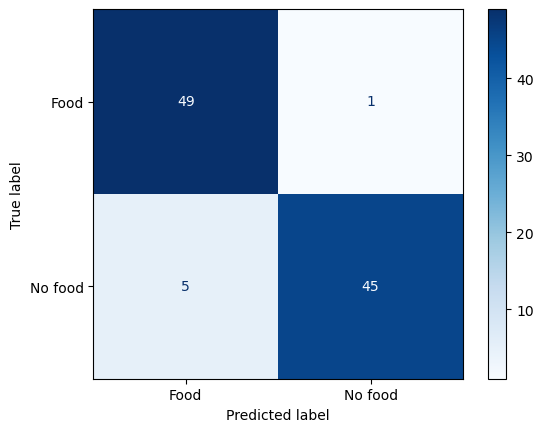

In [17]:
from sklearn.metrics import ConfusionMatrixDisplay
ConfusionMatrixDisplay.from_predictions(y_true=targets, y_pred=predictions, 
                                        display_labels=['Food', 'No food'], cmap=plt.cm.Blues)

**Actividades propuestas**

- Entrenar el modelo anterior con más épocas
- Entrenar el modelo anterior sin pre-entrenamiento
- Entrenar un modelo tipo Lenet5 sobre el dataset anterior
- Comparar los resultados obtenidos entre los distintos modelos.
